This notebook shows how to run and compare different reservoirs.

**Timings are currently off due to not having jitted everything yet.**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov  9 23:29:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 27.3 gigabytes of available RAM



In [ ]:
!pip install --upgrade pip # To support manylinux2010 wheels
!pip install --upgrade "jax[cuda111]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # GPU
!pip install flax
!git clone https://github.com/GJBoth/jacho.git
%cd jacho
!sudo pip install . 

     |████████████████████████████████| 1.7 MB 4.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 786 kB 4.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.2.24-py3-none-any.whl size=903112 sha256=af7c0dbea392fdf99a1ab66c387f6a3f08b7c4b610a06846ea0c3ebb2253fa7a
  Stored in directory: /root/.cache/pip/wheels/28/a9/0f/3497740c85f6e1de8f4d291fd2f77d046d66a87620143d0d0e
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.2.21
    Uninstalling jax-0.2.21:
      Successfully uninstalled jax-0.2.21
     |████████████████████████████████| 207 kB 4.0 MB/s            
     |████████████████████████████████| 118 kB 47.2 MB/s            
     |████████████████████████████████| 57 kB 4.8 MB/s 

In [ ]:
from jacho.layers.reservoirs import RandomReservoir, StructuredTransform, FastStructuredTransform, SparseReservoir
from jacho.models.generic import GenericEchoState
from jacho.layers.output import Residual
from jacho.training.training import ridge
from jacho.data.KS import KS

from jax import random
import numpy as np
import jax.numpy as jnp
from jax import jit
from flax import linen as nn

import matplotlib.pyplot as plt

key = random.PRNGKey(42)

# Making data

In [ ]:
# Setting up our dataset; similar to jonathans
L = 22 / (2 * np.pi)  # length
N = 32  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 1000
N_init = 1000  # remove the initial points
tend = (N_train + N_test + N_init - 1) * dt

np.random.seed(2)
dns = KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()

In [ ]:
# Prepping train and test matrices
# inputs need to be size [time_steps, samples, spatial_points]
# i.e. here they are [10000, 1, 100]
u = np.expand_dims(dns.uu, axis=1)
_, u_train, u_test = np.split(u / np.sqrt(N), 
                                     [N_init, 
                                     (N_init + N_train)], axis=0)

# Random reservoir

First one is a fully connected random reservoir:

In [ ]:
# Setting up random model
n_reservoir = 2000
reservoir_args = (0.3, 0.5, 0.5) #input_scale, reservoir_scale, bias_scale

n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, RandomReservoir, reservoir_args,
                  n_out, Residual, output_layer_args)

state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [ ]:
# Running reservoir
# new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

In [ ]:
# %%timeit
# its been compiled in the background -  no need for jit when timing but run once before timing and block_until_ready() is important
# model.apply(params, state, u_train, method=model.run_reservoir)[0].block_until_ready()

In [ ]:
# Training - as also runs the reservoir! Should be able to easily change if you want to
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2, n_init=50)

In [ ]:
# %%timeit
# ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2, n_init=50)[0].block_until_ready()

In [ ]:
# Predicting
n_predict_steps = N_test
end_of_predict_state, (prediction, _) = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

In [ ]:
# %%timeit
# model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)[1][0].block_until_ready()

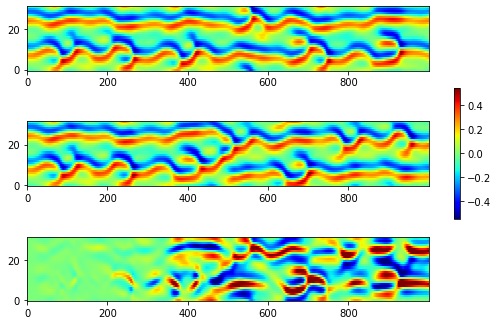

In [ ]:
data = [np.nan_to_num(u_test.squeeze().T), np.nan_to_num(prediction.squeeze()[:].T)]


vmin = np.min(data)
vmax = np.max(data)

fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,6))
data_ = data + [u_test.squeeze()[:].T - prediction.squeeze()[:].T]
for i in range(3):
  im=axs[i].imshow(data_[i], cmap=plt.get_cmap('jet'), interpolation='nearest', 
                   aspect = 5, vmin=vmin, vmax=vmax)
  axs[i].invert_yaxis()
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

# Slow structured prediction

This version explicitly calculates the hadamard matrix and multiplies with it.

In [ ]:
# Setting up random model
n_reservoir = 2000
reservoir_args = (0.38, 0.88, 0.8) #input_scale, reservoir_scale, bias_scale

n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, StructuredTransform, reservoir_args,
                  n_out, Residual, output_layer_args)



state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [ ]:
# Running reservoir
# new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

In [ ]:
# Training - currently runs the reservoir as well but should change.
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2)

In [ ]:
# Predicting
n_predict_steps = N_test
end_of_predict_state, (prediction, _) = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

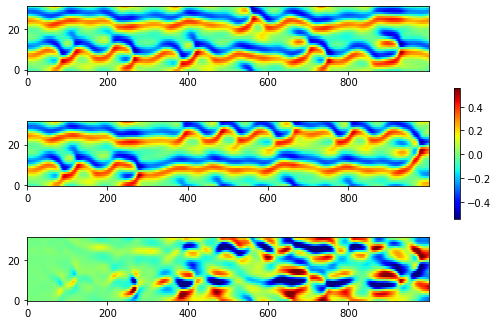

In [ ]:
data = [np.nan_to_num(u_test.squeeze().T), np.nan_to_num(prediction.squeeze()[:].T)]

vmin = np.min(data)
vmax = np.max(data)

fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,6))
data_ = data + [u_test.squeeze()[:].T - prediction.squeeze()[:].T]
for i in range(3):
  im=axs[i].imshow(data_[i], cmap=plt.get_cmap('jet'), interpolation='nearest', 
                   aspect = 5, vmin=vmin, vmax=vmax)
  axs[i].invert_yaxis()
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

# Fast Structured prediction

In [ ]:
# Setting up random model
n_reservoir = 2000
# reservoir_args = (0.88, 0.74, 1.67) #input_scale, reservoir_scale, bias_scale
# reservoir_args = (0.805, 0.52, 2.1) #input_scale, reservoir_scale, bias_scale
reservoir_args = (0.38, 0.88, 0.8) #input_scale, reservoir_scale, bias_scale


n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, FastStructuredTransform, reservoir_args,
                  n_out, Residual, output_layer_args)



state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [ ]:
# Running reservoir
# new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

In [ ]:
# Training - currently runs the reservoir as well but should change.
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2)

In [ ]:
# Predicting
n_predict_steps = N_test
end_of_predict_state, (prediction, _) = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

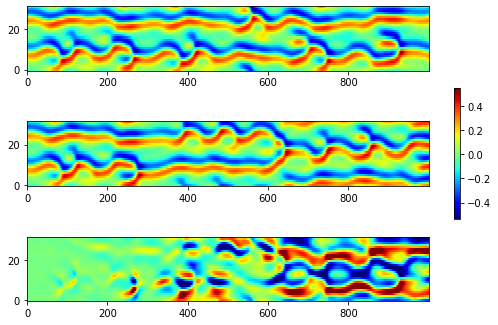

In [ ]:
data = [np.nan_to_num(u_test.squeeze().T), np.nan_to_num(prediction.squeeze()[:].T)]


vmin = np.min(data)
vmax = np.max(data)

fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,6))
data_ = data + [u_test.squeeze()[:].T - prediction.squeeze()[:].T]
for i in range(3):
  im=axs[i].imshow(data_[i], cmap=plt.get_cmap('jet'), interpolation='nearest', 
                   aspect = 5, vmin=vmin, vmax=vmax)
  axs[i].invert_yaxis()
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

# Sparse 

In [ ]:
# Setting up sparse model model
n_reservoir = 2000
reservoir_args = (0.1, 1, 0.2, 0.8) # sparsity level, input_scale, reservoir_scale, bias_scale

n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, SparseReservoir, reservoir_args,
                  n_out, Residual, output_layer_args)

state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [ ]:
# Running reservoir
# new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

In [ ]:
# Training - currently runs the reservoir as well but should change.
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2)

In [ ]:
# Predicting
n_predict_steps = N_test
end_of_predict_state, (prediction, _) = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

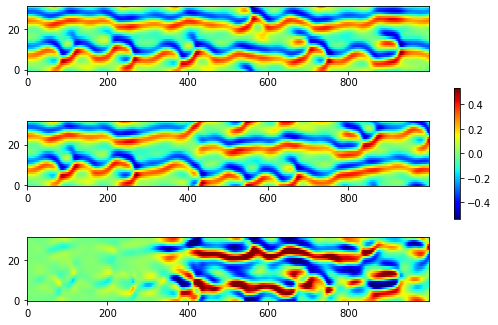

In [ ]:
data = [np.nan_to_num(u_test.squeeze().T), np.nan_to_num(prediction.squeeze()[:].T)]

vmin = np.min(data)
vmax = np.max(data)

fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,6))
data_ = data + [u_test.squeeze()[:].T - prediction.squeeze()[:].T]
for i in range(3):
  im=axs[i].imshow(data_[i], cmap=plt.get_cmap('jet'), interpolation='nearest', 
                   aspect = 5, vmin=vmin, vmax=vmax)
  axs[i].invert_yaxis()
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

There's an error here too....

# Recurrent kernel

In [ ]:
from jacho.recurrent_kernel import RecurrentKernel, erf_kernel, train

In [ ]:
model = RecurrentKernel(erf_kernel, 50, 0.11, (0.4, 0.7, 4.5))
key = random.PRNGKey(42)
params = model.init(key, u_train.squeeze())

In [ ]:
# forward pass to get kernel etc
model.apply(params, u_train.squeeze(), method=model.train_kernel);

In [ ]:
model_state = train(model, params, u_train.squeeze(), alpha=1e-4)

In [ ]:
prediction = model.apply(params, u_train.squeeze(), model_state, length=N_test, method=model.predict)

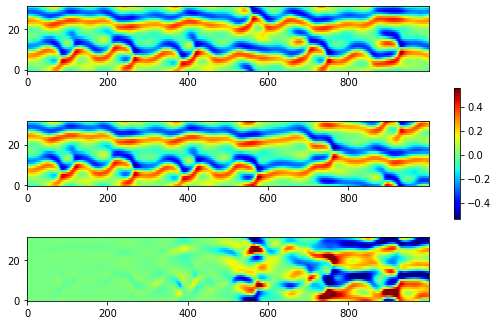

In [ ]:
data = [np.nan_to_num(u_test.squeeze().T), np.nan_to_num(prediction.squeeze()[:].T)]

vmin = np.min(data)
vmax = np.max(data)

fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,6))
data_ = data + [u_test.squeeze()[:].T - prediction.squeeze()[:].T]
for i in range(3):
  im=axs[i].imshow(data_[i], cmap=plt.get_cmap('jet'), interpolation='nearest', 
                   aspect = 5, vmin=vmin, vmax=vmax)
  axs[i].invert_yaxis()
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)